In [1]:
# Core data analysis packages
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

from scipy.sparse import csr_matrix 
from sklearn.neighbors import NearestNeighbors
import networkx as nx
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
# import our files
user_artists = pd.read_csv('data/user_artists.dat',sep='\t')
artists = pd.read_csv('data/artists.dat',sep='\t',usecols=['id','name'])
tags = pd.read_csv('data/tags.dat', sep='\t',encoding='latin-1')
uta = pd.read_csv('data/user_taggedartists.dat', sep='\t')
utat = pd.read_csv('data/user_taggedartists-timestamps.dat', sep="\t")
friends = pd.read_csv('data/user_friends.dat', sep='\t')

## Step 2: Exploratory Data Analysis (EDA) and Preprocessing

In [3]:
num_users = user_artists['userID'].nunique()
num_artists = user_artists['artistID'].nunique()
print(f"Total users: {num_users}, Total artists: {num_artists}")

Total users: 1892, Total artists: 17632


In [14]:
#Create a binary version: 1 if a user has played the artist at least 1000 time. We will use this later to decide the commun neighbors.
user_artists['played'] = (user_artists['weight'] > 500).astype(int)

In [15]:
user_artists.weight.describe() # 75% of the users have played the artist less than 187 times. The max is 352698

count     92834.00000
mean        745.24393
std        3751.32208
min           1.00000
25%         107.00000
50%         260.00000
75%         614.00000
max      352698.00000
Name: weight, dtype: float64

## Step 3: Building the Graph Representation

In [16]:
B = nx.Graph()

users = user_artists['userID'].unique()
B.add_nodes_from(users, bipartite='users')

artist_ids = user_artists['artistID'].unique()
artist_nodes = [f"artist_{artist}" for artist in artist_ids]
B.add_nodes_from(artist_nodes, bipartite='artists')

edges = []
for row in user_artists.itertuples(index=False):
    if row.played == 1:
        user_id = row.userID
        artist_id = row.artistID
        # Append the edge only when played == 1
        edges.append((user_id, f"artist_{artist_id}", row.played))

B.add_weighted_edges_from(edges)

print("Total nodes in bipartite graph:", B.number_of_nodes())
print("Total edges in bipartite graph:", B.number_of_edges())


Total nodes in bipartite graph: 19524
Total edges in bipartite graph: 28127


## Step 3: Build the user-user graph

In [17]:
from networkx.algorithms import bipartite

# Project the bipartite graph onto the user nodes.
user_graph = bipartite.weighted_projected_graph(B, users)

print("Total nodes in user graph:", user_graph.number_of_nodes())
print("Unique users:", len(users)) # just to ensure what we are doing is correct

Total nodes in user graph: 1892
Unique users: 1892


In [18]:
print("Total nodes in user graph:", user_graph.number_of_nodes())
print("Total edges in user graph:", user_graph.number_of_edges())

Total nodes in user graph: 1892
Total edges in user graph: 298302


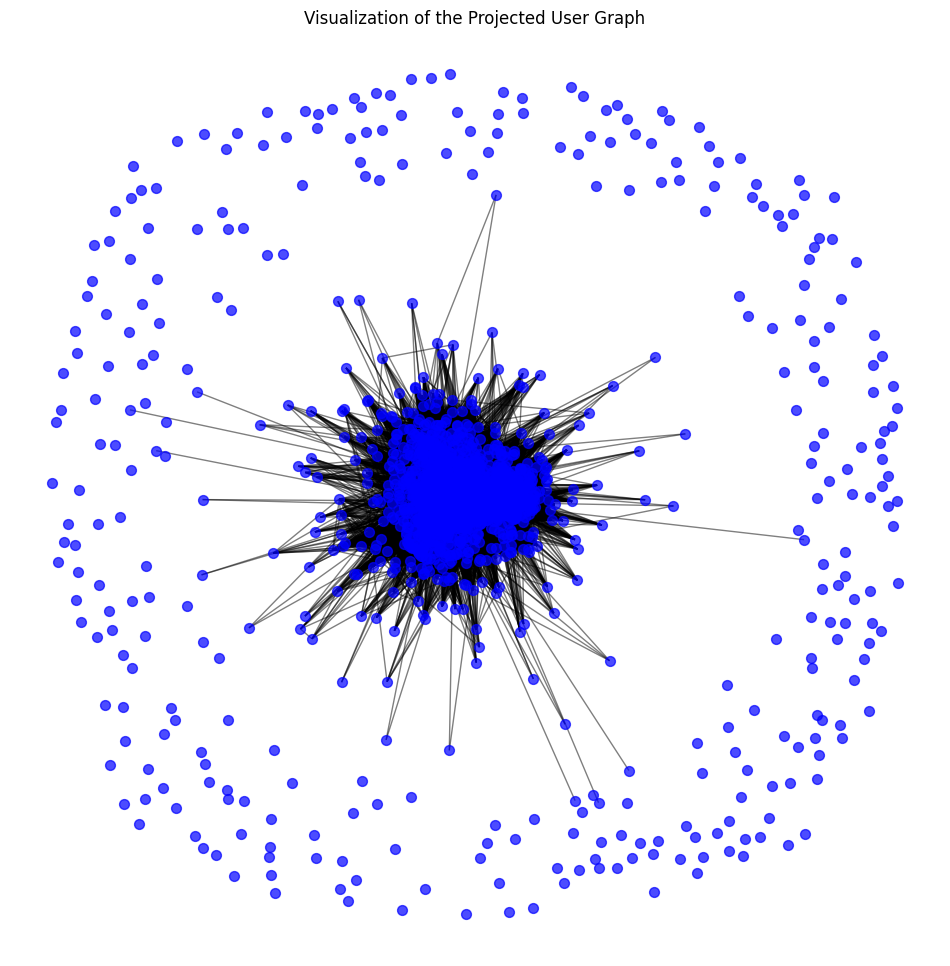

In [19]:
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(user_graph, k=0.1, iterations=20)
nx.draw_networkx_nodes(user_graph, pos, node_size=50, node_color='blue', alpha=0.7)
nx.draw_networkx_edges(user_graph, pos, alpha=0.5)
plt.title("Visualization of the Projected User Graph")
plt.axis('off')
plt.show()

## Step 4: Graph-based similarity methods:

### Jaccard Coefficient

In [29]:
# Create candidate pairs (for all pairs where u < v)
candidate_pairs = [(u, v) for u in user_graph.nodes() for v in user_graph.nodes() if u < v]

# 1. Jaccard Coefficient
jaccard_gen = nx.jaccard_coefficient(user_graph, candidate_pairs)
jaccard_df = pd.DataFrame(jaccard_gen, columns=['user1', 'user2', 'jaccard'])

### Adamic–Adar Index

In [30]:
# 2. Adamic–Adar Index
adamic_gen = nx.adamic_adar_index(user_graph, candidate_pairs)
adamic_df = pd.DataFrame(adamic_gen, columns=['user1', 'user2', 'adamic_adar'])

### Common Neighbors

In [31]:
# 3. Common Neighbors for a specific pair:
def common_neighbors_score(u, v, G):
    """Return the number of common neighbors between u and v."""
    return len(list(nx.common_neighbors(G, u, v)))

In [27]:
# Create a DataFrame to store the scores
pairs_df = pd.DataFrame(candidate_pairs, columns=['user1', 'user2'])

pairs_df['common_neighbors'] = pairs_df.apply(lambda row: common_neighbors_score(row['user1'], row['user2'], user_graph), axis=1)

In [32]:
pairs_df = pairs_df.merge(jaccard_df, on=['user1', 'user2'])
pairs_df = pairs_df.merge(adamic_df, on=['user1', 'user2'])

pairs_df.head()

,user1,user2,common_neighbors,jaccard,adamic_adar
0,2,3,1,0.001361,0.159902
1,2,4,325,0.367232,53.339691
2,2,5,163,0.186712,25.587141
3,2,6,0,0.000000,0.000000
4,2,7,485,0.541295,76.426815


## Step 5: Thresholding the scores to decide music friends

In [51]:
scores = pairs_df['common_neighbors'].values

scores_adamic = pd.Series(scores)
scores_adamic.quantile(0.9) # we will consider the 90% percentile as a threshold to decide if two users are music friends or not

np.float64(291.0)

In [52]:
threshold_aa = 46
threshold_jc = 0.38
threshold_cn = 291

pairs_df['mf_aa'] = pairs_df['adamic_adar'] > threshold_aa
pairs_df['mf_jc'] = pairs_df['jaccard'] > threshold_jc
pairs_df['mf_cn'] = pairs_df['common_neighbors'] > threshold_cn

In [53]:
pairs_df.head()

,user1,user2,common_neighbors,jaccard,adamic_adar,mf_aa,mf_jc,mf_cn
0,2,3,1,0.001361,0.159902,False,False,False
1,2,4,325,0.367232,53.339691,True,False,True
2,2,5,163,0.186712,25.587141,False,False,False
3,2,6,0,0.000000,0.000000,False,False,False
4,2,7,485,0.541295,76.426815,True,True,True


## Step 5: Evaluation metrics

In [ ]:
friendship_pairs = set((row.userID, row.friendID) for row in friends.itertuples(index=False))